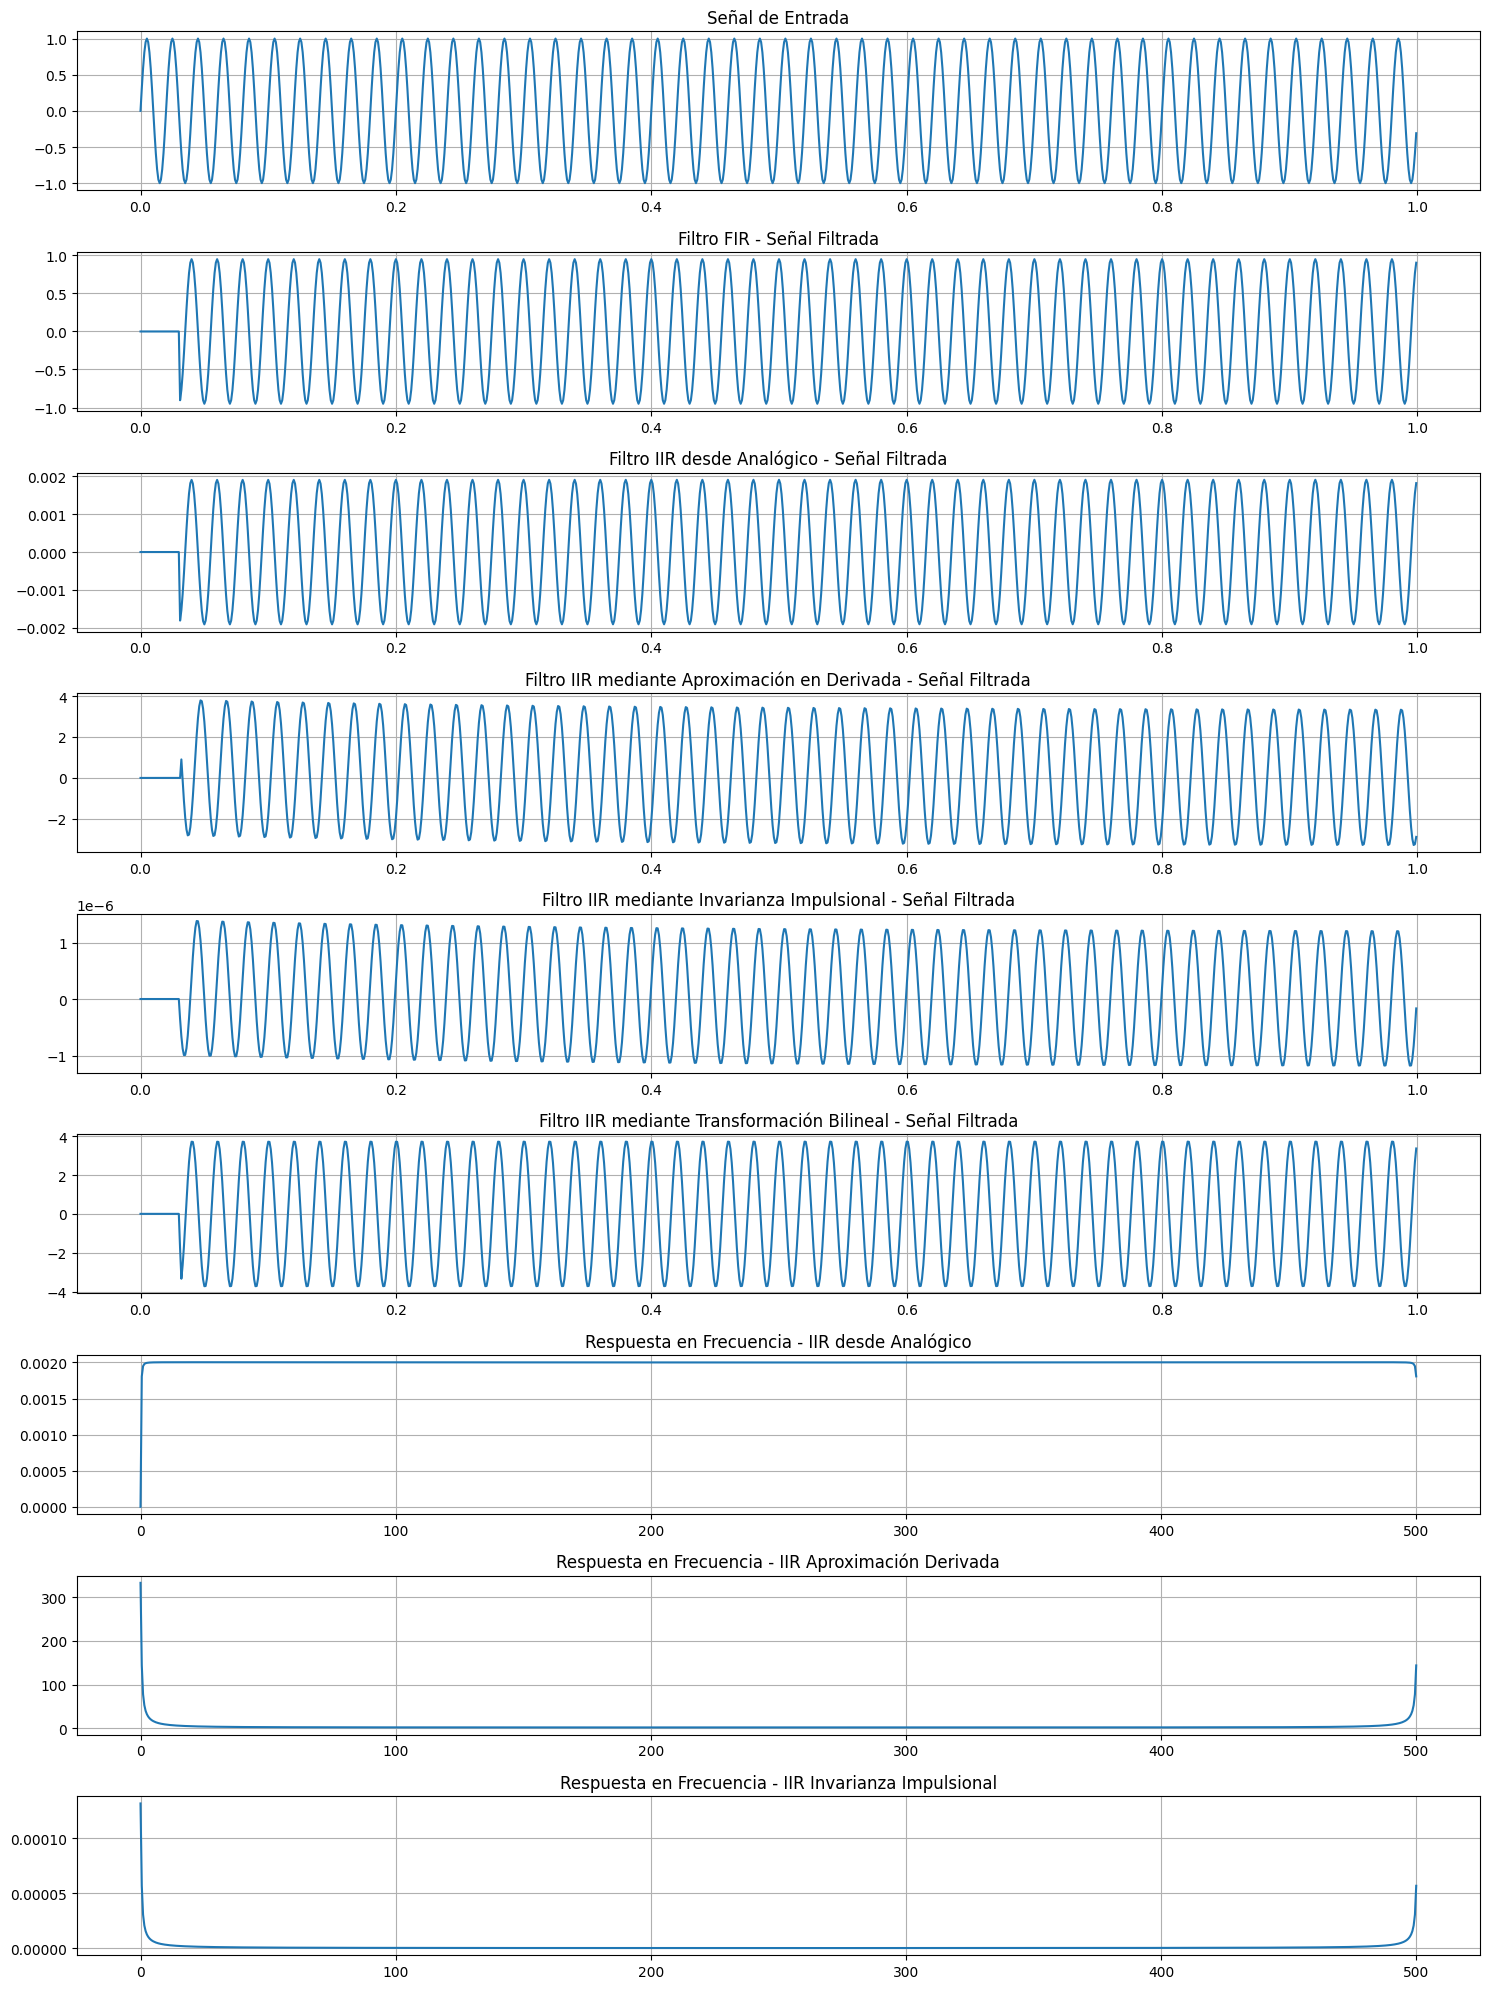

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def design_fir_filter(cutoff_freq, num_taps, window_type='hamming'):
    # Diseño del filtro FIR en frecuencia
    taps = np.zeros(num_taps)
    for i in range(num_taps):
        if i - (num_taps - 1) / 2 == 0:
            taps[i] = 2 * np.pi * cutoff_freq
        else:
            taps[i] = np.sin(2 * np.pi * cutoff_freq * (i - (num_taps - 1) / 2)) / (i - (num_taps - 1) / 2)
        if window_type == 'hamming':
            taps[i] *= 0.54 - 0.46 * np.cos(2 * np.pi * i / (num_taps - 1))  # Hamming window
        elif window_type == 'blackman':
            taps[i] *= 0.42 - 0.5 * np.cos(2 * np.pi * i / (num_taps - 1)) + 0.08 * np.cos(4 * np.pi * i / (num_taps - 1))  # Blackman window
    taps /= sum(taps)  # Normalización
    return taps

def apply_fir_filter(signal, filter_taps):
    num_taps = len(filter_taps)
    filtered_signal = np.zeros_like(signal)
    for i in range(num_taps, len(signal)):
        filtered_signal[i] = np.sum(signal[i - num_taps + 1 : i + 1] * filter_taps)
    return filtered_signal

def design_iir_from_analog(cutoff_freq, fs, order=2):
    w_c = 2 * np.pi * cutoff_freq / fs
    s = w_c / np.tan(w_c / 2)

    a1 = -(2 * fs - s) / (2 * fs + s)
    a2 = 2 / (2 * fs + s)

    b0 = 1 + a1
    b1 = -(1 + a1)
    b2 = 0

    a = np.array([1, a1, a2])
    b = np.array([b0, b1, b2])

    return b, a

def design_iir_derivative(cutoff_freq, fs, order=2):
    w_c = 2 * np.pi * cutoff_freq / fs
    s = w_c / np.tan(w_c / 2)

    a1 = -(2 * fs - s) / (2 * fs + s)
    a2 = 2 / (2 * fs + s)

    b0 = -a2
    b1 = a1
    b2 = 1 - a1

    a = np.array([1, a1, a2])
    b = np.array([b0, b1, b2])

    return b, a

def design_iir_impulse_invariance(cutoff_freq, fs, order=2):
    w_c = 2 * np.pi * cutoff_freq / fs
    s = w_c / np.tan(w_c / 2)

    a1 = -(2 * fs - s) / (2 * fs + s)
    a2 = 2 / (2 * fs + s)

    b0 = w_c**2
    b1 = 0
    b2 = 0

    a = np.array([1, a1, a2])
    b = np.array([b0, b1, b2])

    return b, a

def design_iir_bilinear(cutoff_freq, fs, order=2):
    w_c = 2 * np.pi * cutoff_freq / fs
    s = w_c / np.tan(w_c / 2)

    a1 = -(2 * fs - s) / (2 * fs + s)
    a2 = 2 / (2 * fs + s)

    b0 = 1 - a1
    b1 = 0
    b2 = a1 - 1

    a = np.array([1, a1, a2])
    b = np.array([b0, b1, b2])

    return b, a

def apply_iir_filter(signal, b, a):
    filtered_signal = np.zeros_like(signal)
    for n in range(len(signal)):
        filtered_signal[n] = b[0] * signal[n]
        for k in range(1, len(b)):
            if n - k >= 0:
                filtered_signal[n] += b[k] * signal[n - k]
        for k in range(1, len(a)):
            if n - k >= 0:
                filtered_signal[n] -= a[k] * filtered_signal[n - k]
    return filtered_signal

def compute_frequency_response(b, a, fs):
    num_points = 1000
    freq_response = np.zeros(num_points, dtype=complex)
    for i in range(num_points):
        omega = 2 * np.pi * i / num_points
        z = np.exp(1j * omega)
        num = np.polyval(b, z)
        den = np.polyval(a, z)
        freq_response[i] = num / den
    return freq_response

def design_multistage_filter(signal, fs):
    fir_cutoff_frequency = 0.1
    fir_num_taps = 31
    iir_cutoff_frequency = 0.1
    iir_order = 2

    # Diseño del filtro FIR
    fir_filter = design_fir_filter(fir_cutoff_frequency, fir_num_taps, window_type='blackman')
    fir_output_signal = apply_fir_filter(signal, fir_filter)

    # Diseño del filtro IIR desde filtro analógico
    iir_analog_b, iir_analog_a = design_iir_from_analog(iir_cutoff_frequency, fs)
    iir_analog_output_signal = apply_iir_filter(fir_output_signal, iir_analog_b, iir_analog_a)
    freq_response_analog = compute_frequency_response(iir_analog_b, iir_analog_a, fs)

    # Diseño del filtro IIR mediante aproximación en derivada
    iir_derivative_b, iir_derivative_a = design_iir_derivative(iir_cutoff_frequency, fs)
    iir_derivative_output_signal = apply_iir_filter(fir_output_signal, iir_derivative_b, iir_derivative_a)
    freq_response_derivative = compute_frequency_response(iir_derivative_b, iir_derivative_a, fs)

    # Diseño del filtro IIR mediante invarianza impulsional
    iir_impulse_invariance_b, iir_impulse_invariance_a = design_iir_impulse_invariance(iir_cutoff_frequency, fs)
    iir_impulse_invariance_output_signal = apply_iir_filter(fir_output_signal, iir_impulse_invariance_b, iir_impulse_invariance_a)
    freq_response_impulse = compute_frequency_response(iir_impulse_invariance_b, iir_impulse_invariance_a, fs)

    # Diseño del filtro IIR mediante transformación bilineal
    iir_bilinear_b, iir_bilinear_a = design_iir_bilinear(iir_cutoff_frequency, fs)
    iir_bilinear_output_signal = apply_iir_filter(fir_output_signal, iir_bilinear_b, iir_bilinear_a)
    freq_response_bilinear = compute_frequency_response(iir_bilinear_b, iir_bilinear_a, fs)

    return (fir_output_signal, iir_analog_output_signal, iir_derivative_output_signal,
            iir_impulse_invariance_output_signal, iir_bilinear_output_signal,
            freq_response_analog, freq_response_derivative, freq_response_impulse, freq_response_bilinear)

# Generación de la señal de entrada (una suma de dos frecuencias)
fs = 1000  # Frecuencia de muestreo
t = np.arange(0, 1, 1/fs)
input_signal = np.sin(2 * np.pi * 50 * t)

# Diseño del filtro multietapa
(fir_output, iir_analog_output, iir_derivative_output, iir_impulse_invariance_output,
 iir_bilinear_output, freq_response_analog, freq_response_derivative, freq_response_impulse,
 freq_response_bilinear) = design_multistage_filter(input_signal, fs)

# Gráficos
plt.figure(figsize=(15, 20))

plt.subplot(9, 1, 1)
plt.plot(t, input_signal, label='Señal de entrada')
plt.title('Señal de Entrada')
plt.grid(True)

plt.subplot(9, 1, 2)
plt.plot(t, fir_output, label='Señal filtrada con FIR')
plt.title('Filtro FIR - Señal Filtrada')
plt.grid(True)

# Gráfico para el filtro IIR desde filtro analógico
plt.subplot(9, 1, 3)
plt.plot(t, iir_analog_output, label='Señal filtrada con IIR (Analógico)')
plt.title('Filtro IIR desde Analógico - Señal Filtrada')
plt.grid(True)

# Gráfico para el filtro IIR mediante aproximación en derivada
plt.subplot(9, 1, 4)
plt.plot(t, iir_derivative_output, label='Señal filtrada con IIR (Derivada)')
plt.title('Filtro IIR mediante Aproximación en Derivada - Señal Filtrada')
plt.grid(True)

# Gráfico para el filtro IIR mediante invarianza impulsional
plt.subplot(9, 1, 5)
plt.plot(t, iir_impulse_invariance_output, label='Señal filtrada con IIR (Impulsional)')
plt.title('Filtro IIR mediante Invarianza Impulsional - Señal Filtrada')
plt.grid(True)

# Gráfico para el filtro IIR mediante transformación bilineal
plt.subplot(9, 1, 6)
plt.plot(t, iir_bilinear_output, label='Señal filtrada con IIR (Bilineal)')
plt.title('Filtro IIR mediante Transformación Bilineal - Señal Filtrada')
plt.grid(True)

# Gráfico para la respuesta en frecuencia del filtro IIR desde filtro analógico
plt.subplot(9, 1, 7)
plt.plot(np.linspace(0, fs / 2, len(freq_response_analog)), np.abs(freq_response_analog), label='Magnitud')
plt.title('Respuesta en Frecuencia - IIR desde Analógico')
plt.grid(True)

# Gráfico para la respuesta en frecuencia del filtro IIR mediante aproximación en derivada
plt.subplot(9, 1, 8)
plt.plot(np.linspace(0, fs / 2, len(freq_response_derivative)), np.abs(freq_response_derivative), label='Magnitud')
plt.title('Respuesta en Frecuencia - IIR Aproximación Derivada')
plt.grid(True)

# Gráfico para la respuesta en frecuencia del filtro IIR mediante invarianza impulsional
plt.subplot(9, 1, 9)
plt.plot(np.linspace(0, fs / 2, len(freq_response_impulse)), np.abs(freq_response_impulse), label='Magnitud')
plt.title('Respuesta en Frecuencia - IIR Invarianza Impulsional')
plt.grid(True)



plt.tight_layout()
plt.show()
